In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import h5py

In [4]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import io


Using TensorFlow backend.


# Load the Data

In [5]:
# Assign the data path.
data_path = "hin.txt"

# Read in the data.
lines = io.open(data_path, encoding = "utf-8").read().split("\n")
lines  = lines[:-1]
print(lines[1])
# Split the data into input and target sequences.
lines = [line.split("\t") for line in lines]
print(lines[0])
# We define the starting signal to be "\t" and the
# ending signal to be "\n". These signals tell the
# model that when it sees "\t" it should start
# producing its translation and produce "\n" when
# it wants to end its translation. Let us add
# "\t" to the start and "\n" to the end 
# of all input and output sentences.
lines = [("\t" + line[0] + "\n", "\t" + line[1] + "\n") for
            line in lines]

Jump.	उछलो.
['Help!', 'बचाओ!']


In [7]:
print (lines[0][1])

	बचाओ!



# Figure out the Best Lengths of Sentences

## Compute Sentence Lengths

In [8]:
# Compute the input and output lengths.
input_lengths = np.array([len(line[0]) for line in lines])
output_lengths = np.array([len(line[1]) for line in lines])

In [36]:
print("Input samples=", len(input_lengths))
print("output Sampls=", len(output_lengths))


Input samples= 2869
output Sampls= 2869


(75.0, 80.0, 0.0, 120.0)

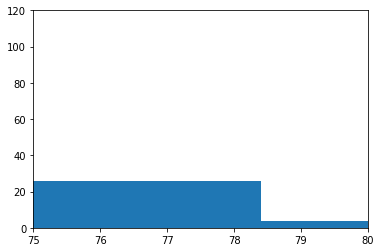

In [10]:
plt.hist(input_lengths)
plt.axis([75,80, 0 , 120])

(85.0, 89.0, 0.0, 20.0)

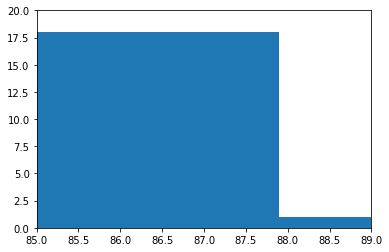

In [11]:
plt.hist(output_lengths)
plt.axis([85,89,0,20])

In [12]:
english = 78
hindi = 87

In [13]:
line1 = []
for i in range(len(input_lengths)):
    if(input_lengths[i]<75 and output_lengths[i]<85):
        line1 = line1 + [lines[i]]
        

In [14]:
print(len(line1))

2856


## Input Length

Plotted the histogram of the length of the input sentences and choose the length that makes the most sense. 

The reason we don't want sentences that are too long is because the computation becomes trickier for longer sentences and the performance also degrades. However we also want as many sentences in our dataset as possible.

Thus it is important to choose the right length and discard sentences longer than this.

## Output Length

Repeat the same for the lengths of the output sentences

In [15]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 2869  # Number of samples to train on.

In [16]:
input_texts = [(line[0]) for line in line1]
target_texts = [(line[1]) for line in line1]

In [17]:
input_characters = set()
target_characters = set()

In [18]:
for input_text in input_texts:
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)

for target_text in target_texts:
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [19]:
print(len(input_characters))
print(len(target_characters))

72
92


In [20]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [21]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 2856
Number of unique input tokens: 72
Number of unique output tokens: 92
Max sequence length for inputs: 74
Max sequence length for outputs: 82


In [22]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [23]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [24]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [25]:

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [26]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


In [27]:
epochs = 100

In [27]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=epochs,validation_split=0.2)

Train on 2284 samples, validate on 572 samples
Epoch 1/100
2284/2284 [==============================] - 47s 21ms/step - loss: 1.2284 - val_loss: 1.9019
Epoch 2/100
2284/2284 [==============================] - 40s 17ms/step - loss: 1.1319 - val_loss: 1.8678
Epoch 3/100
2284/2284 [==============================] - 38s 17ms/step - loss: 1.1290 - val_loss: 1.7525
Epoch 4/100
2284/2284 [==============================] - 40s 17ms/step - loss: 1.0081 - val_loss: 1.6189
Epoch 5/100
2284/2284 [==============================] - 49s 21ms/step - loss: 0.9196 - val_loss: 1.4952
Epoch 6/100
2284/2284 [==============================] - 55s 24ms/step - loss: 0.8673 - val_loss: 1.4573
Epoch 7/100
2284/2284 [==============================] - 67s 29ms/step - loss: 0.8244 - val_loss: 1.4195
Epoch 8/100
2284/2284 [==============================] - 43s 19ms/step - loss: 0.8034 - val_loss: 1.3386
Epoch 9/100
2284/2284 [==============================] - 38s 17ms/step - loss: 0.7667 - val_loss: 1.2996
Epoch 10

Epoch 78/100
2284/2284 [==============================] - 43s 19ms/step - loss: 0.2502 - val_loss: 1.4519
Epoch 79/100
2284/2284 [==============================] - 39s 17ms/step - loss: 0.2461 - val_loss: 1.4566
Epoch 80/100
2284/2284 [==============================] - 40s 18ms/step - loss: 0.2429 - val_loss: 1.4803
Epoch 81/100
2284/2284 [==============================] - 39s 17ms/step - loss: 0.2392 - val_loss: 1.4836
Epoch 82/100
2284/2284 [==============================] - 40s 17ms/step - loss: 0.2354 - val_loss: 1.4905
Epoch 83/100
2284/2284 [==============================] - 40s 17ms/step - loss: 0.2313 - val_loss: 1.4987
Epoch 84/100
2284/2284 [==============================] - 39s 17ms/step - loss: 0.2274 - val_loss: 1.5370
Epoch 85/100
2284/2284 [==============================] - 39s 17ms/step - loss: 0.2263 - val_loss: 1.5244
Epoch 86/100
2284/2284 [==============================] - 39s 17ms/step - loss: 0.2218 - val_loss: 1.5377
Epoch 87/100
2284/2284 [======================

In [1]:
model.save('s2s.h5')

NameError: name 'model' is not defined

In [28]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [32]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence


In [33]:
for seq_index in range(100):
    
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print(input_texts[seq_index])
    print(decoded_sentence)

-
	Help!

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Jump.

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Jump.

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Jump.

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Hello!

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Hello!

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Cheers!

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Cheers!

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Got it?

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	I'm OK.

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Awesome!

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|

-
	I like math.

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	I'll attend.

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Nobody came.

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Was I wrong?

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	What's this?

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Are you sick?

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Bring him in.

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Come with us.

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Happy Easter!

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४४पृृईछंेेट्ओाध
-
	Has Tom left?

ाफफ्ओलओललझ५५-श!ऑकमउबॉऔौऑऑऑबद.....ज़५५|"४पृृंेउछडयट!न्रणःणू़-शैशदख़ख़ख़ख़४४